Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.
  Location              time  temp  precipitation  humidity  dew_point  \
0  Calgary  01-01-2020 00:00   1.4            0.0        68       -3.9   
1  Calgary  01-01-2020 01:00   1.1            0.0        68       -4.2   
2  Calgary  01-01-2020 02:00   0.8            0.0        68       -4.4   
3  Calgary  01-01-2020 03:00   1.0            0.0        67       -4.3   
4  Calgary  01-01-2020 04:00   1.0            0.0        68       -4.3   

   apparent_temp  rain snowfall  snow_depth  ...  cloud_cover  wind_speed  \
0           -4.4   0.0        0        0.22  ...          100        21.6   
1           -4.5   0.0        0        0.22  ...          100        20.0   
2           -4.8   0.0        0        0.22  ...           96        19.9   
3           -4.4   0.0        s        0.22  ...           99        18.7   
4           -3.

<ipython-input-36-5d41c11d0f5e>:14: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/

Forecasted exogenous variables:
                     precipitation   humidity  cloud_cover  season_Spring  \
2025-03-24 00:00:00       0.004044  43.656743    95.027081            1.0   
2025-03-24 01:00:00       0.005938  45.746434    90.998039            1.0   
2025-03-24 02:00:00       0.007281  48.126224    87.501153            1.0   
2025-03-24 03:00:00       0.008393  50.633762    84.696281            1.0   
2025-03-24 04:00:00       0.009348  53.098270    82.233878            1.0   

                     season_Summer  season_Winter  weather_description_Rain  \
2025-03-24 00:00:00            0.0            0.0                  0.000174   
2025-03-24 01:00:00            0.0            0.0                  0.000256   
2025-03-24 02:00:00            0.0            0.0                  0.000314   
2025-03-24 03:00:00            0.0            0.0                  0.000361   
2025-03-24 04:00:00            0.0            0.0                  0.000403   

                     weather_d

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



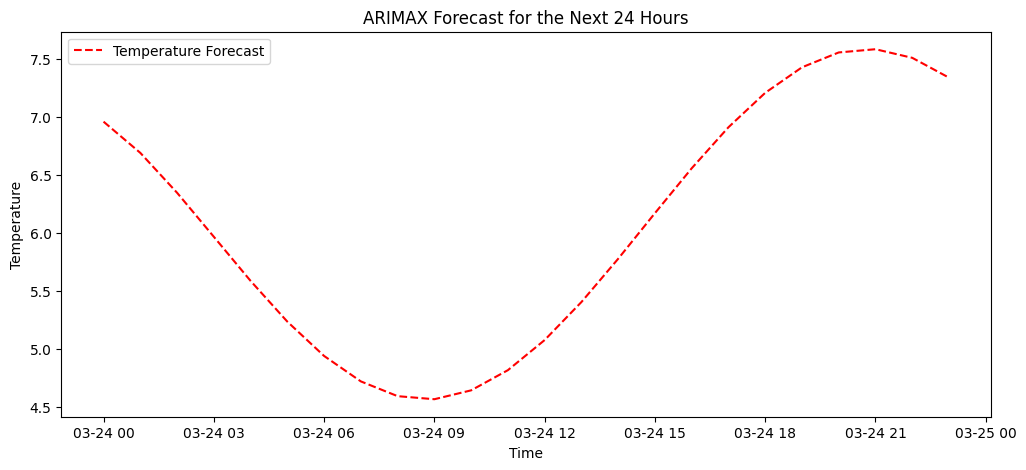

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Mount Google Drive for Colab
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/Assignment_Data607/Calgary.csv'
try:
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
    print(data.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

# Ensure 'time' column is datetime and set it as the index
data['time'] = pd.to_datetime(data['time'], format="%d-%m-%Y %H:%M", dayfirst=True)
data.set_index('time', inplace=True)

# Select relevant columns
df = data[['temp', 'precipitation', 'humidity', 'cloud_cover', 'season', 'weather_description']].copy()

# Preprocess categorical variables (e.g., season and weather_description)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[['season', 'weather_description']])
encoded_columns = encoder.get_feature_names_out(['season', 'weather_description'])

# Combine with the original DataFrame
df_encoded = pd.concat(
    [df[['temp', 'precipitation', 'humidity', 'cloud_cover']],
     pd.DataFrame(encoded_features, columns=encoded_columns, index=df.index)],
    axis=1
)

# Separate the target variable (temp) and exogenous variables
target = df_encoded['temp']
exog = df_encoded.drop(columns=['temp'])

# Forecast future exogenous variables
forecast_steps = 24

# Function to forecast an exogenous variable using ARIMA
def forecast_exog(series, steps):
    model = ARIMA(series, order=(2, 1, 2))  # Example ARIMA parameters; tune as needed
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(hours=1),
                                   periods=steps, freq='h')
    return pd.Series(forecast, index=forecast_index)

# Forecast each exogenous variable
exog_forecasts = {}
for col in exog.columns:
    exog_forecasts[col] = forecast_exog(exog[col], forecast_steps)

# Combine forecasted exogenous variables into a DataFrame
future_exog = pd.DataFrame(exog_forecasts)
print("Forecasted exogenous variables:")
print(future_exog.head())

# Fit ARIMAX model using historical data
p, d, q = 2, 1, 3
model = ARIMA(target, order=(p, d, q), exog=exog)
model_fit = model.fit()

# Forecast the target variable (temp) using the future exogenous variables
temp_forecast = model_fit.forecast(steps=forecast_steps, exog=future_exog)

# Create forecast index
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq="h")[1:]
forecast_series = pd.Series(temp_forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_series.index, forecast_series, label='Temperature Forecast', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title(f'ARIMAX Forecast for the Next {forecast_steps} Hours')
plt.legend()
plt.show()
